In [1]:
import os

# Set datapath properly
path = os.getcwd() + "/data/"

if not os.path.exists(path):
  os.makedirs(path)

%env DATAPATH={path}

raw_segy = '../seismic.segy'
raw = 's.rsf'
raw_hfile = 's_hfile.rsf'
raw_tfile = 's_tfile.txt'
raw_bfile = 's_bfile.txt'
cdp_mask = "cdp_mask.rsf"

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.PythonPlot as plt
import seaborn as sns
from rsf.proj import *
import rsf.api as sf

env: DATAPATH=/home/kerim/Documents/JUDI.jl/examples/field_examples/viking_graben_line12/proc/data/


Read SEGY and separate headers

In [2]:
!sfsegyread < {raw_segy} > {raw} tfile={raw_tfile} hfile={raw_hfile} bfile={raw_bfile}
!sfheaderattr < {raw_tfile}

91 headers, 120120 traces
******************************************************************************* 
     key     	            min     	              max    	          mean
------------------------------------------------------------------------------- 
tracl       0              1 @ 0	        120120 @ 120119	       60060.5
tracr       1              1 @ 0	        120120 @ 120119	       60060.5
fldr        2              3 @ 0	          1003 @ 120000	           503
tracf       3              1 @ 0	           120 @ 119	          60.5
ep          4            101 @ 0	          1112 @ 120000	       608.012
cdp         5              1 @ 0	          2142 @ 120119	       1074.52
cdpt        6              1 @ 0	           120 @ 119	          60.5
trid        7              1 @ 0	             1 @ 0	             1
nhs         9              1 @ 0	             1 @ 0	             1
offset     11          -3237 @ 0	          -262 @ 119	       -1749.5
gelev      12            -10 @ 0	      

In [3]:
in_h = sf.Input(raw_tfile)
print('n1:', in_h.int('n1'))
print('n2:', in_h.int('n2'))

data_h = np.zeros((in_h.int('n2'), in_h.int('n1')), dtype=np.float32)
in_h.read(data_h)

# Iterate over file w/ SEG-Y keyword/index relation
keys = {}

for index, row in pd.read_csv('keys.txt', sep=' ').iterrows():
  keys[row.key] = row.id

df_h = pd.DataFrame()

for k in keys:
  df_h[k] = data_h[:,keys[k]]

df_h[['offset', 'ep', 'cdp', 'sx', 'gx']].head()

n1: 91
n2: 120120


,offset,ep,cdp,sx,gx
0,-3237.0,101.0,1.0,3237.0,0.0
1,-3212.0,101.0,2.0,3237.0,25.0
2,-3187.0,101.0,3.0,3237.0,50.0
3,-3162.0,101.0,4.0,3237.0,75.0
4,-3137.0,101.0,5.0,3237.0,100.0


### Investigating the line geometry with some QC plots

Check if source is sequatial

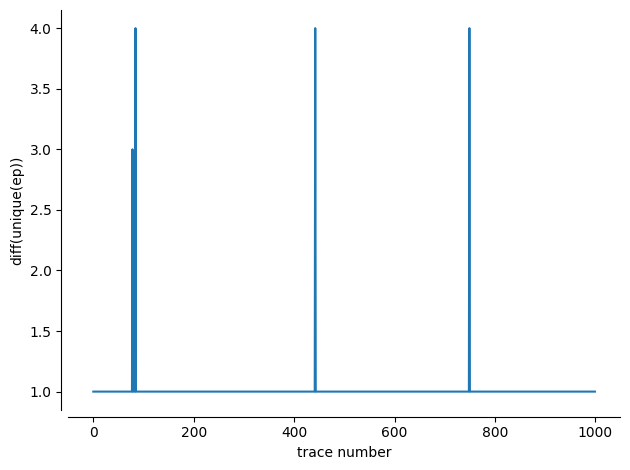

In [4]:
plt.plot(np.diff(df_h.ep.unique()))

plt.xlabel('trace number')
plt.ylabel('diff(unique(ep))')

plt.axis('tight')
sns.despine(offset=5)
plt.tight_layout()

Thus shot points are not sequential, otherwise all values would have equal values.

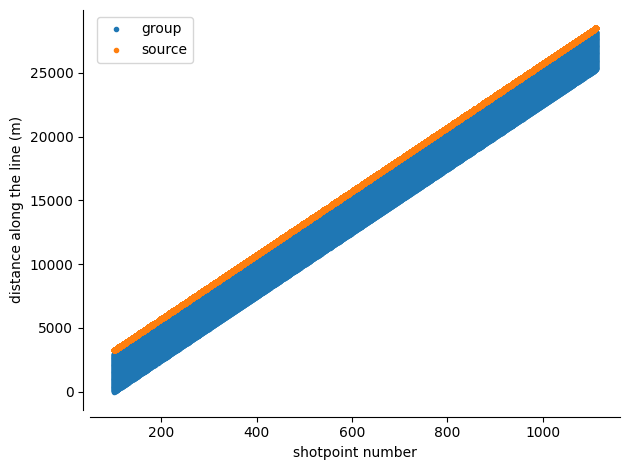

In [5]:
plt.plot(df_h.ep, df_h.gx, '.', label='group')
plt.plot(df_h.ep, df_h.sx, '.', label='source')

plt.legend(loc='upper left')

plt.xlabel('shotpoint number')
plt.ylabel('distance along the line (m)')

plt.axis('tight')
sns.despine(offset=5)
plt.tight_layout()

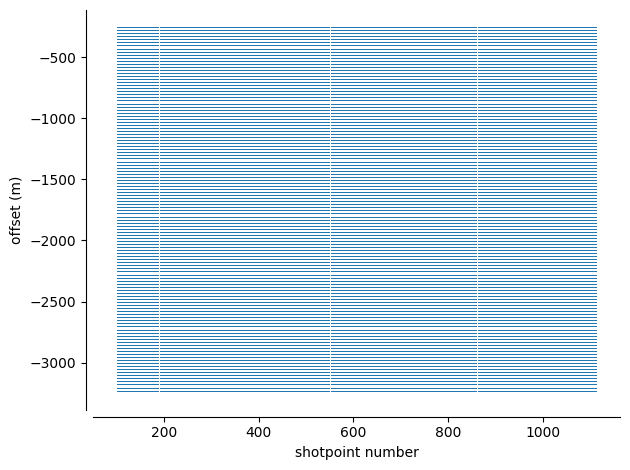

In [6]:
plt.plot(df_h.ep, df_h.offset, ',')

plt.xlabel('shotpoint number')
plt.ylabel('offset (m)')

plt.axis('tight')
sns.despine(offset=5)
plt.tight_layout()

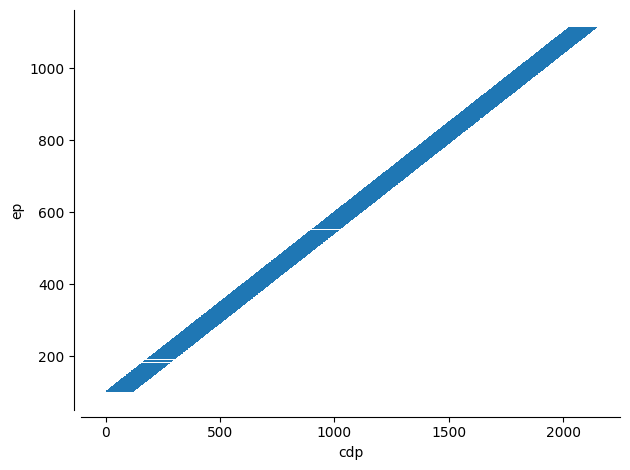

In [7]:
plt.plot(df_h.cdp, df_h.ep, ',')

plt.xlabel('cdp')
plt.ylabel('ep')

plt.axis('tight')
sns.despine(offset=5)
plt.tight_layout()

### Recovering the original group number

This survey is stack array, since 262 m/25 m ~ 10.5, so we can recover the group number with the following expression

In [8]:
# grnofr - geophone group number of trace
df_h['grnofr'] = df_h.ep - 10.5 - np.abs(df_h.tracf - 120)

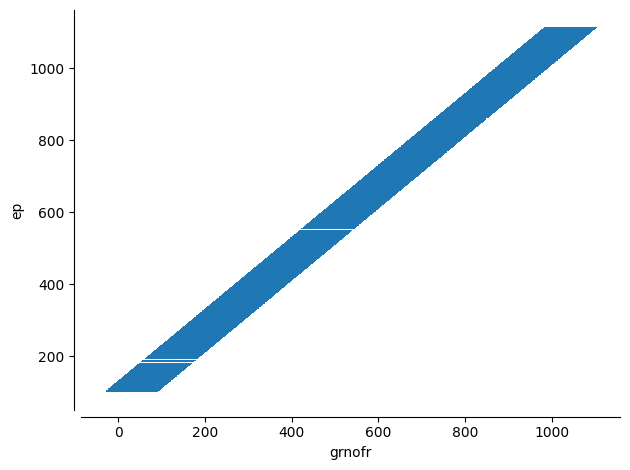

In [9]:
plt.plot(df_h.grnofr, df_h.ep, ',')

plt.xlabel('grnofr')
plt.ylabel('ep')

plt.axis('tight')
sns.despine(offset=5)
plt.tight_layout()

In [10]:
offset = (df_h['ep'] - df_h['grnofr'])  * 25
# 0.5 m is the difference between the real minimum offset and
# the offset to make this survey a perfect stack array
offset -= 0.5
# Also, all offsets are negative
offset = -offset

# Lets check if the provided offset and calculated offset matches
np.allclose(offset, df_h['offset'])

True

In [11]:
# Lets check if the sequential CDP provided and our
# calculated CDP matches

cdp = (df_h.ep + df_h.grnofr)/2
bins = cdp.unique()
np.allclose(df_h.cdp, np.digitize(cdp, bins))

True

In [12]:
# Now lets create a sequential group number for sorting purposes
# grnors - 
bins = df_h.grnofr.unique()
df_h['grnors'] = np.digitize(df_h.grnofr, bins)

In [13]:
# We also need a equivalent to CDPT for for common group sorting
# grnlof - geophone group number of the roll sw pos 1
df_h['offset_bin'] = df_h.grnofr - df_h.ep
df_h['grnlof'] = df_h.groupby('grnors', group_keys=False).offset_bin.apply(np.argsort)

In [14]:
# Since there is skips, we also need a sequential shotpoint
# lets recicle the fldr keyword
bins = df_h.ep.unique()
fldr = np.digitize(df_h.ep, bins)
df_h['fldr'] = fldr

To properly manipulate the line geometry we need some extra keywords, like sequential shotpoint, proper cdpt, group number and trace number with group ensemble.

### Recovering the original group number

This survey is stack array, since 262 m/25 m ~ 10.5, so we can recover the group number with the following expression

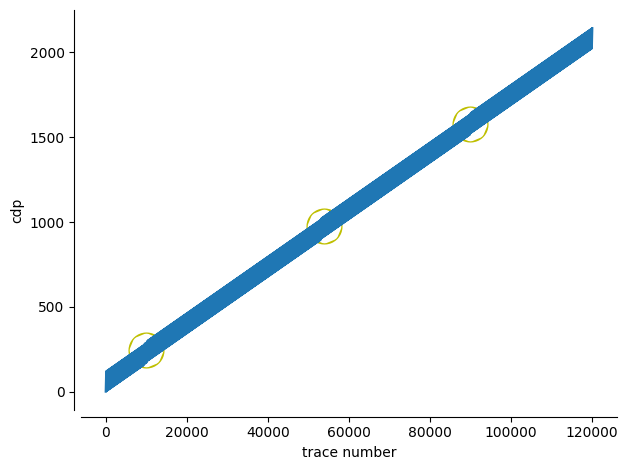

In [15]:
plt.plot(df_h.cdp)

plt.xlabel('trace number')
plt.ylabel('cdp')
plt.scatter(x=10000, y=245, s=1, alpha=1, c='y', linewidths=25)
plt.scatter(x=54000, y=975, s=1, alpha=1, c='y', linewidths=25)
plt.scatter(x=90000, y=1580, s=1, alpha=1, c='y', linewidths=25)

plt.axis('tight')
sns.despine(offset=5)
plt.tight_layout()

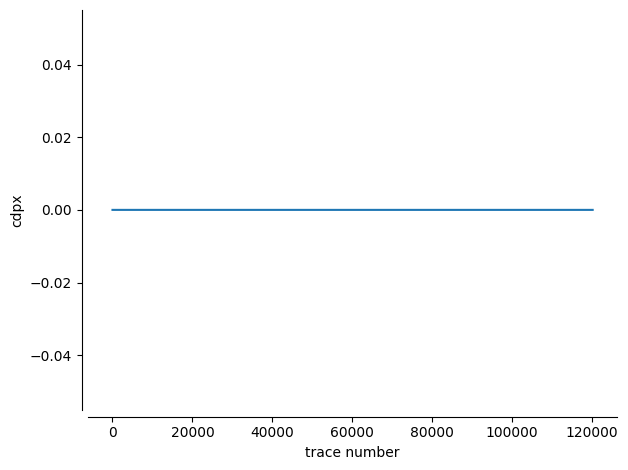

In [16]:
plt.plot(df_h.cdpx)

plt.xlabel('trace number')
plt.ylabel('cdpx')

plt.axis('tight')
sns.despine(offset=5)
plt.tight_layout()

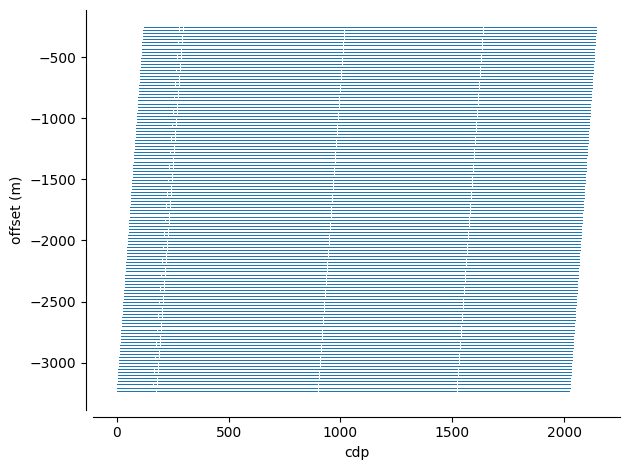

In [17]:
plt.plot(df_h.cdp, df_h.offset, ',')

plt.xlabel('cdp')
plt.ylabel('offset (m)')

plt.axis('tight')
sns.despine(offset=5)
plt.tight_layout()

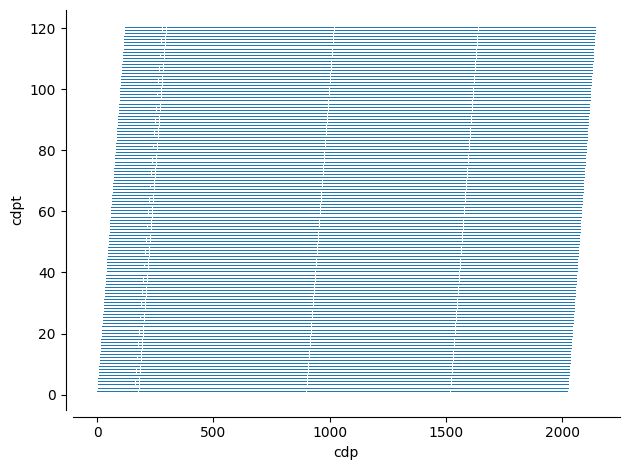

In [18]:
plt.plot(df_h.cdp, df_h.cdpt, ',')

plt.xlabel('cdp')
plt.ylabel('cdpt')

plt.axis('tight')
sns.despine(offset=5)
plt.tight_layout()

## Recalculate a proper CDPT

The original CDPT has skips on it, we need a truly sequential CDPT, otherwise the data in CDP domain will be filled with many zeroed traces.

In [19]:
df_h['cdpt'] = df_h.groupby('cdp', group_keys=False).offset_bin.apply(np.argsort)
df_h.drop('offset_bin', axis=1, inplace=True)

# or we could simply run the following
# df_h['cdpt'] = df_h.groupby('cdp', group_keys=False).offset.apply(np.argsort)

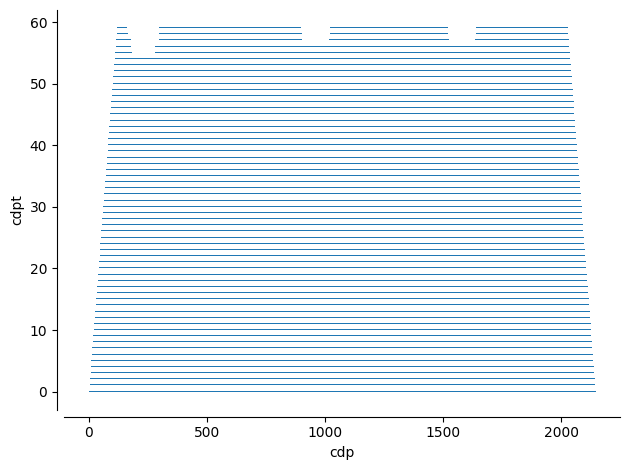

In [20]:
plt.plot(df_h.cdp, df_h.cdpt, ',')

plt.xlabel('cdp')
plt.ylabel('cdpt')

plt.axis('tight')
sns.despine(offset=5)
plt.tight_layout()

In [21]:
for k in keys:
    data_h[:,keys[k]] = df_h[k].values

header_complete = 'sp_header_complete.rsf'
header_complete_int = 'sp_header_complete_int.rsf'

out = sf.Output(header_complete)
out.put('n1', in_h.int('n1'))
out.put('n2', in_h.int('n2'))

out.write(data_h)
out.close()

out = sf.Output(header_complete_int)
out.put('n1', in_h.int('n1'))
out.put('n2', in_h.int('n2'))

out.write(data_h.astype(np.int32))
out.close()

Save CDP sorted copy and created CDP mask

In [22]:
proc_cdp = "s_cdp.rsf"
!sfintbin < {raw} yk=cdp xk=cdpt head={header_complete_int} mask={cdp_mask} > {proc_cdp}

offsets = 'offsets.rsf'
!sfheadermath < {header_complete} output='offset'/1000. > {offsets}

cdp_offsets = 'cdp_offsets.rsf'
!sfintbin < {header_complete} head={header_complete_int} yk=cdp xk=cdpt | \
    sfheadermath output='offset'/1000. > {cdp_offsets}

sfintbin: 2142 of 2142;
sfintbin: 2142 of 2142;
